In [6]:
import numpy as np
import pickle
import csv
import torch
from torch.linalg import inv, eig, pinv
from matplotlib import pyplot as plt
from tools import whiten, adap_whitening, adap_whitening_2
from sklearn import svm, metrics
from sklearn.decomposition import PCA
from datetime import datetime
import sklearn
import pickle

In [7]:
def load(filename, reduced=True):
    sensor_data = []
    times = []
    responding_sens = [0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0]
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        # times = [row[0] for row in reader]
        for row in reader:
            if row[0] =='Timestamp':
                continue
            else:
                times.append(row[0])
                values = []
                for i in range(17):
                    b1 = int(row[2*i+1])
                    b2 = int(row[2*i+2])
                    values.append(int.from_bytes([b1, b2], byteorder="little"))
                sensor_data.append(values)
    sensor_data = np.array(sensor_data)
    if reduced:
        sensor_data = np.delete(sensor_data, np.where(np.array(responding_sens)==0)[0], axis=1)
    sequence = pickle.load(open('data/1_300_20_sequence.pkl', 'rb'))
    # Convert to seconds
    times_sec = []
    for dt_str in times:
        dt = datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S.%f')
        seconds = dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond / 1e6
        times_sec.append(seconds)
    sequence_sec = []
    for dt_str in sequence:
        dt = datetime.strptime(dt_str[0], '%a %b %d %H:%M:%S %Y')
        seconds = dt.hour * 3600 + dt.minute * 60 + dt.second
        sequence_sec.append(seconds)
    times_sec = np.array(times_sec)
    sequence_sec = np.array(sequence_sec)
    return sensor_data, sequence, times_sec, sequence_sec

In [8]:
def split(data, delay = 1.5, t_baseline = 300, n_train = 225):

    sensor_data = data[0]
    times_sec = data[1]
    sequence_sec = data[2]
    baseline = np.mean(sensor_data[:t_baseline], axis=0)    # Add baseline substraction
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []
    counts = np.zeros((3))

    for i, t in enumerate(sequence_sec):
        try:
            flags = (times_sec > sequence_sec[i]) & (times_sec < sequence_sec[i+1] + delay)
        except IndexError:
            flags = (times_sec > sequence_sec[i])
        sample = sensor_data[flags][:18]

        if counts[sequence[i][1]-1] < n_train//3:
            X_train.append(sample.flatten())
            Y_train.append(sequence[i][1]-1)
            counts[sequence[i][1]-1] += 1
        else:
            X_test.append(sample.flatten())
            Y_test.append(sequence[i][1]-1)

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
    return X_train, Y_train, X_test, Y_test

def estimate_derivative(signal, dt=1):
    """
    Estimate the first derivative of a signal using second-order central difference.

    Parameters:
        signal (np.ndarray): 1D array of signal values.
        dt (float): Sampling interval (time step).

    Returns:
        np.ndarray: Estimated first derivative of the signal.
    """
    n = len(signal)
    derivative = np.zeros_like(signal)

    # Central differences for interior points
    for i in range(1, n - 1):
        derivative[i] = (signal[i + 1] - signal[i - 1]) / (2 * dt)

    # Forward difference for the first point
    derivative[0] = (signal[1] - signal[0]) / dt

    # Backward difference for the last point
    derivative[-1] = (signal[-1] - signal[-2]) / dt

    return derivative

In [153]:
n_hd = 10000
n_out = 3
k = 50
n_pot = 10
n_train = 225
w_teacher = 1.
t_training_delay = 5.
filename = 'data/1_300_20.csv'

grid_uniformW = [False]
grid_normalized = [False]
grid_whitened = [False]
grid_k = [10, 25, 50, 100]
grid_n_pot = [n for n in range(2, 20, 2)]
grid_t_training_delay = [n for n in range(0, 20, 5)]
grid_n_fold = 5


sensor_data, sequence, times_sec, sequence_sec = load(filename, reduced=True)
d_sensor_data = np.apply_along_axis(estimate_derivative, axis=0, arr=sensor_data)
sensor_data = np.hstack((sensor_data, d_sensor_data))

# baseline = np.mean(sensor_data[:300], axis=0)  # Add baseline substraction
# sensor_data = (sensor_data - baseline)

params = {'uniformW': [], 'normalized': [], 'whitened': [], 'k': [], 'n_pot': [], 't_training_delay': [], 'n_fold': []}
results = {'train_acc': [], 'test_acc': []}
for uniformW in grid_uniformW:
    for normalized in grid_normalized:
        for whitened in grid_whitened:
            for k in grid_k:
                for n_pot in grid_n_pot:
                    for t_training_delay in grid_t_training_delay:
                        for n_fold in range(grid_n_fold):
                            for key in params.keys():
                                params[key].append(locals()[key])

                            if normalized:
                                sensor_data_norm = (sensor_data - np.mean(sensor_data, axis=0))/ np.std(sensor_data, axis=0)
                            else:
                                sensor_data_norm = sensor_data

                            # x_dense, _, _, _ = adap_whitening_2(sensor_data_norm)
                            if whitened:
                                x_dense = adap_whitening_2(sensor_data_norm)
                            else:
                                x_dense = sensor_data_norm

                            n_dense = x_dense.shape[1]

                            labels = np.zeros_like(times_sec)
                            for i, t in enumerate(sequence_sec[:n_train]):
                                try:
                                    flag = (times_sec > sequence_sec[i] + t_training_delay) & (times_sec < sequence_sec[i+1])
                                except IndexError:
                                    flag = (times_sec > sequence_sec[i] + t_training_delay)
                                labels[flag] = int(sequence[i][1])

                            idx_last_flag = np.where(labels != 0)[0][-1]

                            if uniformW:
                                W_hd = np.random.uniform(high=1/np.sqrt(n_dense), size=(n_hd, n_dense))  #Test random sparse weights
                            else:
                                W_hd = np.random.binomial(n=1, p=0.05, size=(n_hd, n_dense))  #Test random sparse weights
                            x_hd = x_dense @ W_hd.T
                            z_hd = np.where(np.argsort(x_hd)<k, 1., 0)
                            W_out = np.zeros((n_out, n_hd))
                            W = np.zeros((n_out, n_hd))

                            z_out_train = np.zeros((z_hd.shape[0],  n_out))
                            for i, row in enumerate(z_hd[:idx_last_flag]):
                                teacher = np.zeros((n_out,))
                                if labels[i] != 0:
                                    teacher[int(labels[i]-1)] = w_teacher
                                out = row @ W_out.T + teacher
                                z_out_train[i] = out
                                dW = (1./n_pot)*(np.atleast_2d(out).T @ np.atleast_2d(row))
                                W += dW
                                W_out = np.where(W>=1., 1./k, 0.)
                                # if i%100 == 0:
                                #     print(np.sum(W_out, axis=1))

                            z_out = np.zeros((z_hd.shape[0],  n_out))
                            for i, row in enumerate(z_hd):
                                out = row @ W_out.T
                                z_out[i] = out

                            z_wta = np.where(np.argsort(z_out, axis=1)<1, 1., 0)

                            z_pred = np.zeros_like(sequence_sec)
                            z_true = np.zeros_like(sequence_sec)
                            for i, t in enumerate(sequence_sec):
                                try:
                                    flag = (times_sec > sequence_sec[i] + t_training_delay) & (times_sec < sequence_sec[i+1])
                                except IndexError:
                                    flag = (times_sec > sequence_sec[i] + t_training_delay)
                                z_pred[i] = np.argsort(np.sum(z_out[flag], axis=0))[-1] + 1
                                z_true[i] = sequence[i][1]

                            train_acc = sklearn.metrics.accuracy_score(z_true[:n_train], z_pred[:n_train])
                            test_acc = sklearn.metrics.accuracy_score(z_true[n_train:], z_pred[n_train:])
                            results['train_acc'].append(train_acc)
                            results['test_acc'].append(test_acc)

                            print(f'UniformW: {uniformW}, Normalized: {normalized}, Whitened: {whitened}, k: {k}, n_pot: {n_pot}, t_training_delay: {t_training_delay}, n_fold: {n_fold}')
                            print(f'Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}')

for key in params.keys():
    params[key] = np.array(params[key])
for key in results.keys():
    results[key] = np.array(results[key])

data = {'params': params, 'results': results}

with open('data/gridsearch_raw.pkl', 'wb') as f:
    pickle.dump(data, f)


UniformW: False, Normalized: False, Whitened: False, k: 10, n_pot: 2, t_training_delay: 0, n_fold: 0
Train accuracy: 0.9911, Test accuracy: 0.8000
UniformW: False, Normalized: False, Whitened: False, k: 10, n_pot: 2, t_training_delay: 0, n_fold: 1
Train accuracy: 0.9956, Test accuracy: 0.7333
UniformW: False, Normalized: False, Whitened: False, k: 10, n_pot: 2, t_training_delay: 0, n_fold: 2
Train accuracy: 0.9778, Test accuracy: 0.7600
UniformW: False, Normalized: False, Whitened: False, k: 10, n_pot: 2, t_training_delay: 0, n_fold: 3
Train accuracy: 0.9867, Test accuracy: 0.6000
UniformW: False, Normalized: False, Whitened: False, k: 10, n_pot: 2, t_training_delay: 0, n_fold: 4
Train accuracy: 0.9689, Test accuracy: 0.7200
UniformW: False, Normalized: False, Whitened: False, k: 10, n_pot: 2, t_training_delay: 5, n_fold: 0
Train accuracy: 1.0000, Test accuracy: 0.8800
UniformW: False, Normalized: False, Whitened: False, k: 10, n_pot: 2, t_training_delay: 5, n_fold: 1
Train accuracy: 0

In [33]:
with open('data/gridsearch_50_100.pkl', 'rb') as f:
    data = pickle.load(f)
params = data['params']
results = data['results']

for key in params.keys():
    params[key] = np.array(params[key])
for key in results.keys():
    results[key] = np.array(results[key])

In [154]:
grid_k = [10, 25, 50, 100]
grid_n_pot = [n for n in range(2, 18, 2)]
grid_t_training_delay = [n for n in range(0, 20, 5)]
grid_n_fold = 5

ims = np.zeros((len(grid_k), len(grid_n_pot), len(grid_t_training_delay)))

for i, k in enumerate(grid_k):
    for j, n_pot in enumerate(grid_n_pot):
        for l, t_training_delay in enumerate(grid_t_training_delay):

            flags = np.stack((params['k']==k,
                              params['n_pot']==n_pot,
                              params['t_training_delay']==t_training_delay), axis=1).all(axis=1)
            train_acc = np.mean(results['train_acc'][flags])
            test_acc = np.mean(results['test_acc'][flags])
            ims[i, j, l] = test_acc

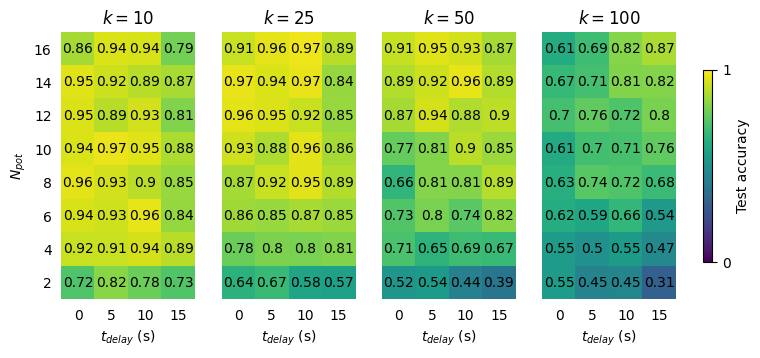

In [159]:
fig, ax = plt.subplots(1, 5, figsize=(10, 5))

for i, k in enumerate(grid_k):
    im = ax[i].imshow(ims[i],
                      cmap='viridis', aspect='equal', origin='lower', vmin=0, vmax=1,
                      # extent=(0, len(grid_t_training_delay), 0, len(grid_n_pot))
                      )
    ax[i].set_xticks(np.arange(len(grid_t_training_delay)), labels=grid_t_training_delay)
    ax[i].set_yticks(np.arange(len(grid_n_pot)), labels=grid_n_pot)
    ax[i].tick_params(left=False, bottom=False)
    ax[i].set_title(f'$k={k}$')
cbar = plt.colorbar(im, ax=ax[4], fraction=1, shrink=0.5)
cbar.set_ticks([0,1])
cbar.set_label('Test accuracy')
ax[-1].set_visible(False)
for a in ax[1:4]:
    a.set_yticks([])
for a in ax[:4]:
    a.set_xlabel('$t_{delay}$ (s)')
    a.spines[:].set_visible(False)
ax[0].set_ylabel('$N_{pot}$')

for l in range(4):
    for (j,i),label in np.ndenumerate(ims[l]):
        ax[l].text(i,j,f'{label:.2}',ha='center',va='center')

plt.savefig('figs/gridsearch_raw.png', dpi=500)
plt.savefig('figs/gridsearch_raw.pdf', dpi=500)
plt.show()

In [160]:
n_hd = 10000
n_out = 3
k = 25
n_pot = 14
n_train = 225
w_teacher = 1.
t_training_delay = 0.
filename = 'data/1_300_20.csv'

x_dense = sensor_data
n_dense = x_dense.shape[1]

labels = np.zeros_like(times_sec)
for i, t in enumerate(sequence_sec[:n_train]):
    try:
        flag = (times_sec > sequence_sec[i] + t_training_delay) & (times_sec < sequence_sec[i+1])
    except IndexError:
        flag = (times_sec > sequence_sec[i] + t_training_delay)
    labels[flag] = int(sequence[i][1])

idx_last_flag = np.where(labels != 0)[0][-1]

W_hd = np.random.binomial(n=1, p=0.05, size=(n_hd, n_dense))  #Test random sparse weights
x_hd = x_dense @ W_hd.T
z_hd = np.where(np.argsort(x_hd)<k, 1., 0)
W_out = np.zeros((n_out, n_hd))
W = np.zeros((n_out, n_hd))

z_out_train = np.zeros((z_hd.shape[0],  n_out))
for i, row in enumerate(z_hd[:idx_last_flag]):
    teacher = np.zeros((n_out,))
    if labels[i] != 0:
        teacher[int(labels[i]-1)] = w_teacher
    out = row @ W_out.T + teacher
    z_out_train[i] = out
    dW = (1./n_pot)*(np.atleast_2d(out).T @ np.atleast_2d(row))
    W += dW
    W_out = np.where(W>=1., 1./k, 0.)
    # if i%100 == 0:
    #     print(np.sum(W_out, axis=1))

z_out = np.zeros((z_hd.shape[0],  n_out))
for i, row in enumerate(z_hd):
    out = row @ W_out.T
    z_out[i] = out

z_wta = np.where(np.argsort(z_out, axis=1)<1, 1., 0)

z_pred = np.zeros_like(sequence_sec)
z_true = np.zeros_like(sequence_sec)
for i, t in enumerate(sequence_sec):
    try:
        flag = (times_sec > sequence_sec[i] + t_training_delay) & (times_sec < sequence_sec[i+1])
    except IndexError:
        flag = (times_sec > sequence_sec[i] + t_training_delay)
    z_pred[i] = np.argsort(np.sum(z_out[flag], axis=0))[-1] + 1
    z_true[i] = sequence[i][1]

train_acc = sklearn.metrics.accuracy_score(z_true[:n_train], z_pred[:n_train])
test_acc = sklearn.metrics.accuracy_score(z_true[n_train:], z_pred[n_train:])

print(f'UniformW: {uniformW}, Normalized: {normalized}, Whitened: {whitened}, k: {k}, n_pot: {n_pot}, t_training_delay: {t_training_delay}, n_fold: {n_fold}')
print(f'Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}')

UniformW: False, Normalized: False, Whitened: False, k: 25, n_pot: 14, t_training_delay: 0.0, n_fold: 4
Train accuracy: 0.9778, Test accuracy: 0.9600


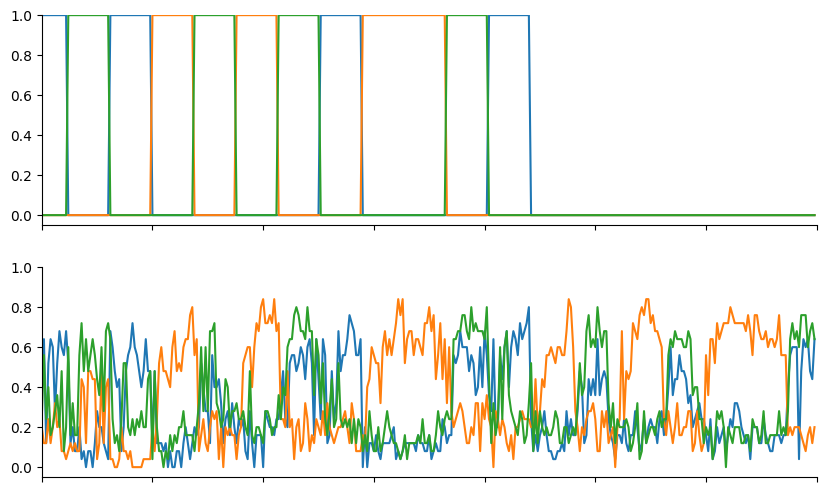

In [161]:
t0 = 4350
t1 = 4700

fig, ax = plt.subplots(2, 1, figsize=(10, 6))

for i in range(3):
    ax[0].plot((labels==i+1)[t0:t1], label=f'Neuron {i+1}')
    ax[1].plot(z_out[t0:t1, i], label=f'Neuron {i+1}')
    ax[1].axvspan()
for a in fig.axes:
    a.spines[['top', 'right']].set_visible(False)
    a.set_xlim([0, t1-t0])
    a.set_ylim([-0.05, 1.])
for a in ax[0:2]:
    a.set_xticklabels([])
# plt.legend(frameon=False, loc='upper right')
plt.savefig('figs/hd_out.pdf', bbox_inches='tight')

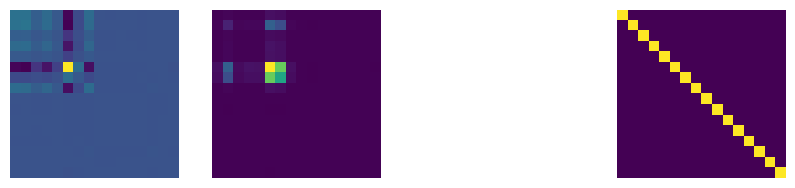

In [109]:
fig, ax = plt.subplots(1,4, figsize = (10,4))

ax[0].imshow(np.cov(sensor_data.T))
ax[1].imshow(np.cov(adap_whitening(sensor_data)[0].T))
ax[2].imshow(np.cov(adap_whitening_2(sensor_data)[0].T))
ax[3].imshow(np.cov(whiten(sensor_data).T))

for a in fig.axes:
    a.set_xticks([])
    a.set_yticks([])
    a.spines[:].set_visible(False)

In [110]:
adap_whitening_2(sensor_data)

(tensor([[ 5.1300e+02,  4.1770e+03,  3.7600e+02,  ...,  4.5000e+01,
           1.0000e+00, -3.0000e+00],
         [ 8.0599e-11, -7.8663e-12, -6.9672e-11,  ...,  6.7033e-10,
           2.3760e-08, -1.1657e-08],
         [        nan,         nan,         nan,  ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan,  ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan,  ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan,  ...,         nan,
                  nan,         nan]]),
 tensor([[ 3.6297e+03,  5.9486e+03,  3.1908e+03,  ...,  6.2212e+03,
           6.1337e+03,  8.6032e+03],
         [-1.1587e-08,  1.0914e-09, -8.5911e-09,  ...,  8.5091e-10,
           1.6899e-09,  1.5531e-09],
         [        nan,         nan,         nan,  ...,         nan,
                  nan,         nan],
         ...,
         [        nan,   